# Speaker Embeddings in the VoiceLoop VCTK-All Sim
* Extract the learned LUT speaker embeddings from the standard VoiceLoop sim on VCTK-all
* Investigate the relationship between the speakers in the space
* Has the model learned an interpretable embedding space?
* How entangled are the features?

## Imports & Functions

In [ ]:
from __future__ import print_function

import os
import numpy as np

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from model import Loop as Loop_Base

from model_ident import Loop as Loop_Ident

from sklearn.manifold import TSNE

from sklearn.decomposition import PCA

import sklearn.metrics.pairwise as pw

import pandas as pd

from data import *
from utils import generate_merlin_wav

from torch.autograd import Variable
from IPython.display import Audio
import IPython.display

import phonemizer

from scipy.io import wavfile
import spectrogram as sp

import copy

%load_ext autoreload
%autoreload 2

In [2]:
import evaluate_loss_func_for_notebook as el

In [3]:
def get_vtck_speaker_info():
    # this is the reference data file that comes as part of VCTK
    speaker_info_file = os.path.join(vctk_folder, 'speaker-info.txt')

   # read file contents
    f = open(speaker_info_file, 'r')
    x = f.readlines()
    f.close()

    # extract column headers
    cols = x[0].lower().split()
    num_cols = len(cols)
    del x[0]
    num_speaker = len(x)

    # parse the data line by line
    d = dict()

    for idx in range(num_speaker):
        this_speaker_id = int(x[idx][:3])
        this_age = int(x[idx][5:7])
        this_gender = x[idx][9]
        residual = x[idx][14:].split()
        this_accent = residual[0]
        this_region = " ".join(residual[1:])

        # add speakers to a dictionary
        d[this_speaker_id] = (this_speaker_id, this_age, this_gender, this_accent, this_region)

    # convert to Pandas datafrae
    speaker_info = pd.DataFrame.from_dict(d, orient='index', columns=cols)
    
    return speaker_info

In [58]:
def generate_sample_with_loop(npz='', text='', spkr_id=1, 
                              checkpoint='models/vctk-16khz-cmu-no-boundaries-all/bestmodel.pth', 
                              output_dir = './',
                             npz_path = '/home/ubuntu/loop/data/vctk--16khz-cmu-no-boundaries-all/numpy_features',
                             output_file_override=None,
                             ident_override=None):
    #npz = ''
    #text = 'Your tickets for the social issues'
    #text = 'see that girl watch that scene'
    #npz = '/home/ubuntu/loop/data/vctk/numpy_features/p294_011.npz'
    #spkr_id = 12
    #checkpoint = 'checkpoints/vctk/lastmodel.pth'
    #checkpoint = 'models/vctk/bestmodel.pth'
    
    out_dict = dict()
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    gpu = 0

    # load loop weights & params from checkpoint
    weights = torch.load(checkpoint,
                         map_location=lambda storage, loc: storage)
    opt = torch.load(os.path.dirname(checkpoint) + '/args.pth')
    train_args = opt[0]

    train_dataset = NpzFolder('/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features')
    char2code = train_dataset.dict
    spkr2code = train_dataset.speakers
    #print spkr2code.cpu().data

    norm_path = train_args.data + '/norm_info/norm.dat'
    norm_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/norm_info/norm.dat'
    train_args.noise = 0
    
    valid_dataset_path = npz_path + '_valid'

    
    # prepare loop model
    if ident_override:
        model = Loop_Ident(train_args)
    else:
        model = Loop_Base(train_args)
        
    model.load_state_dict(weights)
    if gpu >= 0:
        model.cuda()
    model.eval()

    # check speaker id is valid
    if spkr_id not in range(len(spkr2code)):
        print('ERROR: Unknown speaker id: %d.' % spkr_id)

    # get phone sequence
    txt, feat, spkr, output_fname = None, None, None, None
    if npz is not '':
        # use pre-calculated phonemes etc.
        txt, feat, pre_calc_feat = npy_loader_phonemes(os.path.join(npz_path, npz))

        txt = Variable(txt.unsqueeze(1), volatile=True)
        feat = Variable(feat.unsqueeze(1), volatile=True)
        spkr = Variable(torch.LongTensor([spkr_id]), volatile=True)

        output_file = os.path.basename(npz)[:-4] + '_' + str(spkr_id)
        
        out_dict['pre_calc_feat'] = pre_calc_feat
        
    elif text is not '':
        # use specified text string
        # extract phonemes from the text
        txt = text2phone(text, char2code)
        feat = torch.FloatTensor(txt.size(0)*20, 63)
        spkr = torch.LongTensor([spkr_id])

        txt = Variable(txt.unsqueeze(1), volatile=True)
        feat = Variable(feat.unsqueeze(1), volatile=True)
        spkr = Variable(spkr, volatile=True)

        output_file = text.replace(' ', '_')
    else:
        print('ERROR: Must supply npz file path or text as source.')
        raise Exception('Need source')

    if output_file_override:
        output_file = output_file_override
        
    # use gpu
    if gpu >= 0:
        txt = txt.cuda()
        feat = feat.cuda()
        spkr = spkr.cuda()

    # run loop model to generate output features 
    #print(ident_override)
    if ident_override:
        loop_feat, attn = model([txt, spkr], feat, ident_override=ident_override)
    else:
        loop_feat, attn = model([txt, spkr], feat)
        
    loop_feat, attn = trim_pred(loop_feat, attn)
    
    # add to output dictionary
    out_dict['txt'] = txt[:,0].squeeze().data.tolist()
    out_dict['spkr'] = spkr
    out_dict['feat'] = feat.data.cpu().numpy()
    out_dict['loop_feat'] = loop_feat.data.cpu().numpy()
    out_dict['attn'] = attn.squeeze().data.cpu().numpy()
    out_dict['output_file'] = output_file
    out_dict['valid_dataset_path'] = valid_dataset_path
    
    #print output_dir

    # generate .wav file from loop output features
    generate_merlin_wav(loop_feat.data.cpu().numpy(),
                        output_dir,
                        output_file,
                        norm_path)
    
    
    # generate .wav file from original features for reference
    if npz is not '':
        output_orig_fname = os.path.basename(npz)[:-4] + '.orig'
        generate_merlin_wav(feat[:, 0, :].data.cpu().numpy(),
                            output_dir,
                            output_orig_fname,
                            norm_path)
        out_dict['output_orig_fname'] = output_orig_fname
    
    return out_dict

In [6]:
def generate_samples_for_spkr_list(spkr_id_list, 
                                   npz='', 
                                   text='', 
                                   checkpoint='checkpoints/vctk-16khz-cmu-no-boundaries-all-noise-2/bestmodel.pth', 
                                   output_dir='./', 
                                   npz_path='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features'):

    out = []
    for spkr in spkr_id_list:
        output_file_override = 'gen_test_' + str(spkr)
        loop_dict = generate_sample_with_loop(spkr_id=spkr, 
                                              npz=npz, 
                                              text=text, 
                                              checkpoint=checkpoint_file, 
                                              output_dir ='./',
                                              npz_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features',
                                             output_file_override=output_file_override)
        
        out.append(loop_dict)
        IPython.display.display(Audio(loop_dict['output_file'] + '.wav', autoplay=True))
        
    return out   

In [7]:
def text2phone(text, char2code):
    seperator = phonemizer.separator.Separator('', '', ' ')
    ph = phonemizer.phonemize(text, separator=seperator)
    ph = ph.split(' ')
    ph.remove('')

    ph = [p.replace('zh', 'jh') for p in ph]

    result = [char2code[p] for p in ph]
    return torch.LongTensor(result)

In [8]:
def trim_pred(out, attn):
    tq = attn.abs().sum(1).data

    for stopi in range(1, tq.size(0)):
        col_sum = attn[:stopi, :].abs().sum(0).data.squeeze()

        if type(tq[stopi]) == float:
            if tq[stopi] < 0.5 and col_sum[-1] > 4:
                break
        else:  
            if tq[stopi][0] < 0.5 and col_sum[-1] > 4:
                break

    out = out[:stopi, :]
    attn = attn[:stopi, :]

    return out, attn

In [9]:
def npy_loader_phonemes(path):
    feat = np.load(path)

    txt = feat['phonemes'].astype('int64')
    txt = torch.from_numpy(txt)

    audio = feat['audio_features']
    audio = torch.from_numpy(audio)

    return txt, audio, feat

In [10]:
def plot_attn(data, labels, dict_file):
    labels_dict = dict_file
    labels_dict = {v: k for k, v in labels_dict.iteritems()}
    labels = [labels_dict[x].decode('latin-1') for x in labels]

    plt.figure(figsize=(15,15))
    axarr = plt.subplot()
    axarr.imshow(data.T, aspect='auto', origin='lower', interpolation='nearest', cmap=cm.viridis)
    axarr.set_yticks(np.arange(0, len(data.T)))
    axarr.set_yticklabels(labels, rotation=90)

In [11]:
def plot_pca_by_accent(pca_fit, speaker_info_loop, u_accents_to_show=None, gender_to_show='all'):
    
    idx_m = speaker_info_loop['gender'] == 'M'
    idx_f = speaker_info_loop['gender'] == 'F'

    title_str = 'PCA: Speakers by Accent'
    
    if u_accents_to_show is None:
        u_accents_to_show = speaker_info_loop.accents.unique()
        
    if gender_to_show == 'm':
        idx_gender_to_show = idx_m
        title_str += ' (male)'
    elif gender_to_show == 'f':        
        idx_gender_to_show = idx_f
        title_str += ' (female)'
    else:
        idx_gender_to_show = idx_m==idx_m
        
    for u in u_accents_to_show:
        idx_this_accent = (speaker_info_loop.accents == u) & idx_gender_to_show
        #print(str(idx_this_accent.sum()))
        #print str(np.sum(idx_this_accent))

        plt.scatter(pca_fit[idx_this_accent, 0], pca_fit[idx_this_accent, 1])
        #f_plot = plt.scatter(S_tsne[idx_other, 0], S_tsne[idx_other, 1], c='r', label='other')

    plt.legend(u_accents_to_show, loc='upper left', bbox_to_anchor=(1,1))
    plt.grid()
    plt.title(title_str)
    plt.show()

In [12]:
 def plot_spectrogram_comparison(wav_file_a, wav_file_b, label_a='base', label_b='test',
                                 title="Original Spectrogram", b_mel=False):
        
    ### Parameters ###
    fft_size = 480# 2048 # window size for the FFT
    #step_size = int(fft_size/16) # distance to slide along the window (in time)
    step_size = 160 # distance to slide along the window (in time)
    spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
    lowcut = 500 # Hz # Low cut for our butter bandpass filter
    highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

    # For mels
    n_mel_freq_components = 40# 64 # number of mel frequency channels
    shorten_factor = 1#10 # how much should we compress the x-axis (time)
    start_freq = 300 # Hz # What frequency to start sampling our melS from 
    end_freq = 8000 # Hz # What frequency to stop sampling our melS from

    #loop_dict['output_orig_fname']
    #loop_dict['output_fname']
    
    # load wav file data
    mywav_a = wav_file_a + '.wav'
    mywav_b = wav_file_b + '.wav'
    
    rate_a, data_a = wavfile.read(mywav_a)
    data_a = sp.butter_bandpass_filter(data_a, lowcut, highcut, rate_a, order=1)
    
    rate_b, data_b = wavfile.read(mywav_b)
    data_b = sp.butter_bandpass_filter(data_b, lowcut, highcut, rate_b, order=1)
    
    assert rate_a==rate_b, "Sampling rates don't match"
    
    # pad
    max_len = np.max([len(data_a), len(data_b)])
    
    tmp_a = data_a
    data_a = np.zeros(max_len)
    data_a[:len(tmp_a)] = tmp_a
    
    tmp_b = data_b
    data_b = np.zeros(max_len)
    data_b[:len(tmp_b)] = tmp_b
   

    # create spectrograms
    wav_spectrogram_a = sp.pretty_spectrogram(data_a.astype('float64'), fft_size = fft_size, 
                                           step_size = step_size, log = True, thresh = spec_thresh)

    wav_spectrogram_b = sp.pretty_spectrogram(data_b.astype('float64'), fft_size = fft_size, 
                                           step_size = step_size, log = True, thresh = spec_thresh)
    
    # create mel spectrograms if necessary
    if b_mel:        
         # Generate the mel filters
        mel_filter, mel_inversion_filter = sp.create_mel_filter(fft_size = fft_size,
                                                            n_freq_components = n_mel_freq_components,
                                                            start_freq = start_freq,
                                                            end_freq = end_freq, samplerate=rate_a) # may need to change sample rate
    
        # create mel spectrograms
        mel_spec_a = sp.make_mel(wav_spectrogram_a, mel_filter, shorten_factor = shorten_factor)
        mel_spec_b = sp.make_mel(wav_spectrogram_b, mel_filter, shorten_factor = shorten_factor)
        
        # use mel spectrograms in the plots (hacky, needs tidying up)
        wav_spectrogram_a = np.float64(mel_spec_a)
        wav_spectrogram_b = np.float64(mel_spec_b)

   
    # plot spectrograms and the differences
    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_a), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Spectrogram: ' + wav_file_a + '(' + label_a + ')')

    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_b), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Spectrogram: ' + wav_file_b + '(' + label_b + ')')

    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_b - wav_spectrogram_a), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Difference: (' + wav_file_b + ' - ' + wav_file_a + ') (' + label_b + ' - ' + label_a + ')')

In [13]:
# working directory for the code
os.chdir('/home/ubuntu/loop')

#### Folders

In [14]:
# location of the VCTK dataset
vctk_folder = '/home/ubuntu/VCTK-Corpus/'

# location of the raw pre-calculated feature files for VCTK from Jiameng
vctk_prebuilt_raw_folder = '/home/ubuntu/vctk-16khz-cmu-no-boundaries/'

# location of the float32, train/validation files for VCTK-all
vctk_precalc_folder = 'data/vctk-16khz-cmu-no-boundaries-all'

#vctk_raw_folder = '/home/ubuntu/VCTK-Corpus/'

## Load Basic Reference Data etc.

#### Load the VCTK speaker_info reference data

In [15]:
speaker_info = get_vtck_speaker_info()

#### Map VCTK speaker_info to the speaker IDs in the VoiceLoop sim

In [16]:
loader = el.get_loader(data_path = vctk_precalc_folder)

In [17]:
loop_speaker_lookup = loader.dataset.speakers # dict['p330'] = 88

In [18]:
# Create dict from IDs used inside VoiceLoop to VCTK speaker IDs
speaker_list_vctk = [int(k[1:])for k in loop_speaker_lookup.keys()] # list of VCTK speaker IDs; strip out the 'p'
speaker_dict_vctk_to_loop = dict(zip(speaker_list_vctk, loop_speaker_lookup.values())) # dict['vctk_id] = sim_id
speaker_dict_loop_to_vctk = dict(zip(loop_speaker_lookup.values(), speaker_list_vctk)) # dict['sim_id] = vctk_id

In [19]:
# get dataframe for VCTK reference data indexed by VoiceLoop speaker ID
tmp = pd.DataFrame.from_dict(speaker_dict_loop_to_vctk, orient='index', columns=['id'])
speaker_info_loop = pd.merge(speaker_info, tmp)

In [20]:
# examples
speaker_info_loop.head()

,id,age,gender,accents,region
0,225,23,F,English,Southern England
1,226,22,M,English,Surrey
2,227,38,M,English,Cumbria
3,228,22,F,English,Southern England
4,229,23,F,English,Southern England


In [21]:
# unique accents
u_accents = speaker_info_loop.accents.unique()

In [22]:
# male/female
idx_m = speaker_info_loop['gender'] == 'M'
idx_f = speaker_info_loop['gender'] == 'F'

## Load Speaker Embeddings from Model Checkpoint

In [23]:
#checkpoint = 'models/vctk/bestmodel.pth'

# model checkpoint
checkpoint_file = 'checkpoints/vctk-16khz-cmu-no-boundaries-all-noise-2/bestmodel.pth'
#checkpoint_file = 'checkpoints/vctk-16khz-cmu-no-boundaries-all/lastmodel.pth'

# data for this model
data='data/vctk-16khz-cmu-no-boundaries-all'

# WORLD feature normalisation data
norm_path = 'data/vctk-16khz-cmu-no-boundaries-all/norm_info/norm.dat'

# output embeddings to a file
output_file = '/tmp/embedding_file.npy'

In [28]:
checkpoint_args_path = os.path.join(os.path.dirname(checkpoint_file), 'args.pth')
checkpoint_args = torch.load(checkpoint_args_path)

# restore the model from the checkpoint
checkpoint = torch.load(checkpoint_file,
                     map_location=lambda storage, loc: storage)

model = Loop_Base(checkpoint_args[0])

model.load_state_dict(checkpoint)

# extract the speaker embeddings from the model
embeddings = model.encoder.lut_s.weight.data.numpy()

# save the embeddings
np.save(output_file, embeddings)

In [29]:
# view parameters used the train the model
checkpoint_args[0]

Namespace(K=10, attention_alignment=0.05, batch_size=32, checkpoint='checkpoints/vctk-16khz-cmu-no-boundaries-all/bestmodel.pth', clip_grad=0.5, data='data/vctk-16khz-cmu-no-boundaries-all', epochs=90, expName='checkpoints/vctk-16khz-cmu-no-boundaries-all-noise-2', gpu=0, hidden_size=256, hidden_size_speakers=256, ignore_grad=10000.0, lr=0.0001, max_seq_len=1000, mem_size=20, noise=2, nspk=108, output_size=63, seed=1, seq_len=500, visualize=False, vocabulary_size=44)

In [30]:
# view model structure
model

Loop(
  (encoder): Encoder(
    (lut_p): Embedding(44, 256, max_norm=1.0)
    (lut_s): Embedding(108, 256, max_norm=1.0)
  )
  (decoder): Decoder(
    (attn): GravesAttention(
      (sm): Softmax()
      (N_a): Sequential(
        (0): Linear(in_features=6380, out_features=638, bias=True)
        (1): ReLU()
        (2): Linear(in_features=638, out_features=30, bias=True)
      )
    )
    (N_o): Sequential(
      (0): Linear(in_features=6380, out_features=638, bias=True)
      (1): ReLU()
      (2): Linear(in_features=638, out_features=256, bias=True)
    )
    (output): Linear(in_features=256, out_features=63, bias=True)
    (N_u): Sequential(
      (0): Linear(in_features=6380, out_features=638, bias=True)
      (1): ReLU()
      (2): Linear(in_features=638, out_features=319, bias=True)
    )
    (F_u): Linear(in_features=256, out_features=256, bias=True)
    (F_o): Linear(in_features=256, out_features=256, bias=True)
  )
)

### Quick Checks on the Embeddings

In [31]:
# drop embedding for speaker 108 because there are only 107 speakers in the model
# (nspk=108 when training model, but we actually only have 107 speakers with data 
# so the final row in the LUT hasn't been trained)
# run the checks below without doing the delete if you want to check!
if embeddings.shape[0] == 108:
    embeddings = np.delete(embeddings, -1, axis=0)

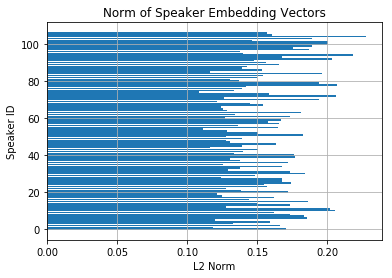

In [32]:
# plot norm of speaker embeddings
plt.barh(range(embeddings.shape[0]), np.sum(embeddings**2,1))
plt.grid(True)
plt.xlabel('L2 Norm')
plt.ylabel('Speaker ID')
plt.title('Norm of Speaker Embedding Vectors')
plt.show()

### Calculate t-sne and PCA

In [33]:
# t-sne
tsne = TSNE(n_components=2)
tsne_fit = tsne.fit_transform(embeddings)

In [34]:
# PCA
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(embeddings)

In [35]:
pca.explained_variance_ratio_

array([ 0.06325465,  0.03509325], dtype=float32)

### Plots: Speakers by Gender

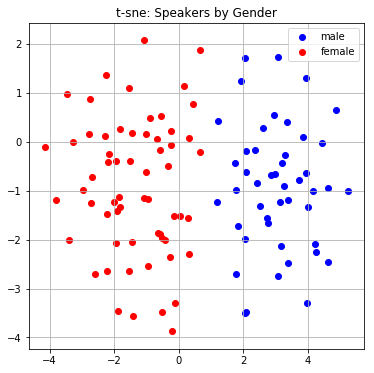

In [36]:
plt.figure(figsize=(6,6))
m_plot = plt.scatter(tsne_fit[idx_m, 0], tsne_fit[idx_m, 1], c='b', label='male')
f_plot = plt.scatter(tsne_fit[idx_f, 0], tsne_fit[idx_f, 1], c='r', label='female')
leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('t-sne: Speakers by Gender')
plt.show()

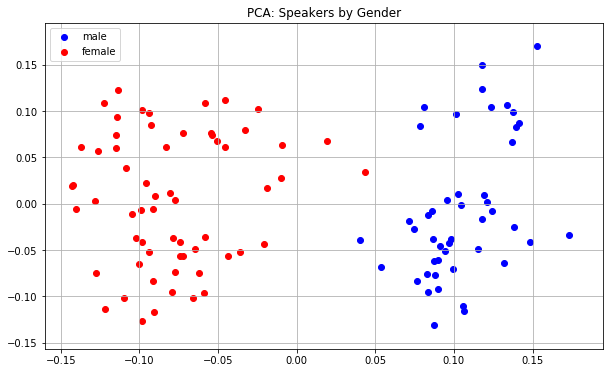

In [37]:
plt.figure(figsize=(10,6))
m_plot = plt.scatter(pca_fit[idx_m, 0], pca_fit[idx_m, 1], c='b', label='male')
f_plot = plt.scatter(pca_fit[idx_f, 0], pca_fit[idx_f, 1], c='r', label='female')
leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('PCA: Speakers by Gender')
plt.show()

### Plots: Speakers by Accent

In [38]:
speaker_info_loop.groupby('accents').count()

,id,age,gender,region
accents,,,,
American,21,21,21,21
Australian,2,2,2,2
Canadian,8,8,8,8
English,33,33,33,33
Indian,3,3,3,3
Irish,9,9,9,9
NewZealand,1,1,1,1
NorthernIrish,6,6,6,6
Scottish,19,19,19,19


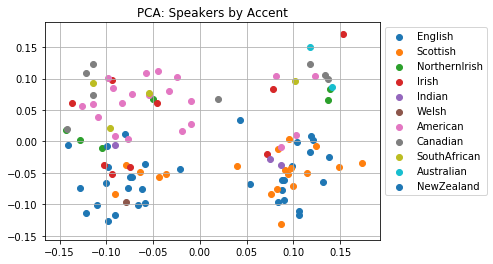

In [39]:
# all speakers
plot_pca_by_accent(pca_fit, speaker_info_loop)

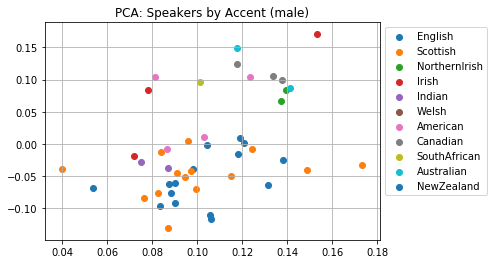

In [40]:
# male speakers
plot_pca_by_accent(pca_fit, speaker_info_loop, 
                   gender_to_show='m')

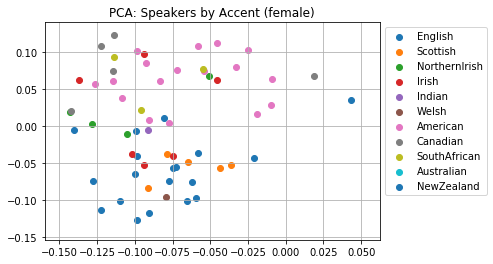

In [41]:
# female speakers
plot_pca_by_accent(pca_fit, speaker_info_loop, 
                   gender_to_show='f')

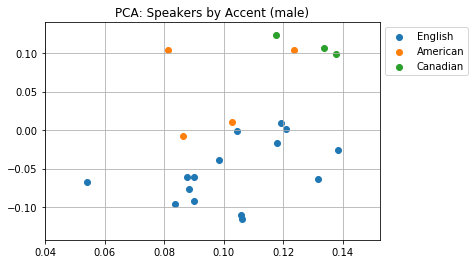

In [42]:
# male speakers, subset of regions
plot_pca_by_accent(pca_fit, speaker_info_loop, 
                   u_accents_to_show=np.array(['English', 'American', 'Canadian']), 
                   gender_to_show='m')

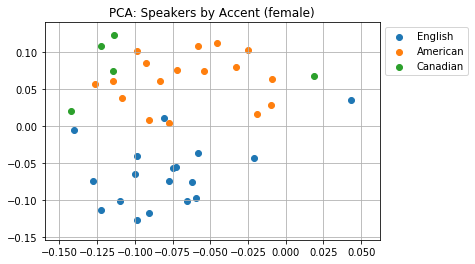

In [43]:
# female speakers, subset of regions
plot_pca_by_accent(pca_fit, speaker_info_loop, 
                   u_accents_to_show=np.array(['English', 'American', 'Canadian']), 
                   gender_to_show='f')

#### English speakers by region

In [44]:
eng = speaker_info_loop[speaker_info_loop.accents == 'English']

In [45]:
u_region = eng.region.unique()

In [46]:
region_map = np.array(['South', 'South', 'North', 'North',
       'Midlands', 'North', 'South', 'South', 'South',
       'Midlands', 'Midlands', 'North', 'North', 'South',
       'South', 'South', 'North', 'North', 'Midlands', 'North'], dtype=object)

In [47]:
region_to_group = dict(zip(u_region, region_map)) # dict['sim_id] = vctk_id

In [48]:
# add RegionGroup to the dataframe
tmp = pd.DataFrame.from_dict(region_to_group, orient='index', columns=['region_group'])
eng_with_group = pd.merge(eng, tmp, left_on='region', right_index=True)

In [49]:
u_region_group = np.unique(region_map)

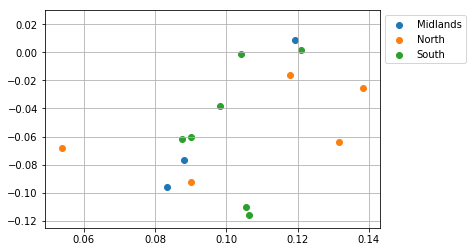

In [50]:
gender_to_show = 'm'

if gender_to_show == 'm':
    idx_gender_to_show = idx_m
    #title_str += ' (male)'
elif gender_to_show == 'f':        
    idx_gender_to_show = idx_f
    #title_str += ' (female)'
else:
    idx_gender_to_show = idx_m==idx_m

for u in u_region_group:
    idx_this_accent = (eng_with_group.region_group == u) & idx_gender_to_show
   
    plt.scatter(pca_fit[idx_this_accent, 0], pca_fit[idx_this_accent, 1])
    #plt.scatter(tsne_fit[idx_this_accent, 0], tsne_fit[idx_this_accent, 1])
   
plt.legend(u_region_group, loc='upper left', bbox_to_anchor=(1,1))
plt.grid()
#plt.title(title_str)
plt.show()

### Cosine Similarity

In [51]:
cosine_sim = pw.cosine_similarity(embeddings)

In [53]:
#speaker_info_loop[speaker_info_loop.accents=='English']

In [60]:
idx_spkr = 39
idx_spkr = 24
idx_spkr = 86
idx_spkr = 26
idx_spkr = 81
idx_spkr = 98
idx_spkr = 55
#idx_spkr = 1

#### Closest Speakers

In [61]:
t = speaker_info_loop.copy()
t['cosine_sim'] = cosine_sim[idx_spkr, :]
t.sort_values('cosine_sim', ascending=False).head(10)

,id,age,gender,accents,region,cosine_sim
55,283,24,F,Irish,Cork,1.000000
39,266,22,F,Irish,Athlone,0.241125
75,307,23,F,Canadian,Ontario,0.167515
60,288,22,F,Irish,Dublin,0.162790
50,277,23,F,English,NE England,0.162063
99,351,21,F,NorthernIrish,Derry,0.155133
12,238,22,F,NorthernIrish,Belfast,0.132402
14,240,21,F,English,Southern England,0.131049
13,239,22,F,English,SW England,0.129371
49,276,24,F,English,Oxford,0.119836


#### Speakers of Same Accent & Gender

In [62]:
t[(t.accents.values == t[t.index == idx_spkr].accents.values)
  & (t.gender.values == t[t.index == idx_spkr].gender.values)].sort_values('cosine_sim', ascending=False)

,id,age,gender,accents,region,cosine_sim
55,283,24,F,Irish,Cork,1.000000
39,266,22,F,Irish,Athlone,0.241125
60,288,22,F,Irish,Dublin,0.162790
64,295,23,F,Irish,Dublin,0.105532
94,340,18,F,Irish,Dublin,0.101890
80,313,24,F,Irish,County Down,0.037185


In [63]:
text = 'How trying to stay cool could make the world even hotter'
spkr_list = list(t.sort_values('cosine_sim', ascending=False).head(5).index)
out = generate_samples_for_spkr_list(spkr_id_list=spkr_list, text=text, checkpoint=checkpoint_file)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete gen_test_55.wav.


{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete gen_test_39.wav.


{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete gen_test_75.wav.


{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete gen_test_60.wav.


{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete gen_test_50.wav.


In [64]:
#plot_attn(out[-1]['attn'], out[-1]['txt'], loader.dataset.dict)

#### Generate sample for a specific speaker ID

In [65]:
# generate the sample
spkr_id = 0
#text = 'The threats would be a major escalation of the dispute and sparked further falls on stock markets.'
text = 'China responded by accusing the US of blackmail'
text = 'How trying to stay cool could make the world even hotter'
#text = 'he picked his tooth up off the floor'
npz='' #'p311_111.npz'
loop_dict = generate_sample_with_loop(spkr_id=spkr_id, 
                                      npz=npz, 
                                      text=text, 
                                      checkpoint=checkpoint_file, 
                                      output_dir ='./',
                                      npz_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features')

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete How_trying_to_stay_cool_could_make_the_world_even_hotter.wav.


In [66]:
# listen to the original (if based on a known sample)
if npz:
    IPython.display.display(Audio(loop_dict['output_orig_fname'] + '.wav', autoplay=True))

In [104]:
# listen to sample synthesized from VoiceLoop features
Audio(loop_dict['output_file'] + '.wav', autoplay=True)

In [105]:
# 50:50
Audio(loop_dict['output_file'] + '.wav', autoplay=True)

In [95]:
# spkr 39
Audio(loop_dict['output_file'] + '.wav', autoplay=True)

In [100]:
# spkr 55
Audio(loop_dict['output_file'] + '.wav', autoplay=True)

In [ ]:
plot_spectrogram_comparison(fname_a, output_file_hack, label_a, 'hack', b_mel=False)

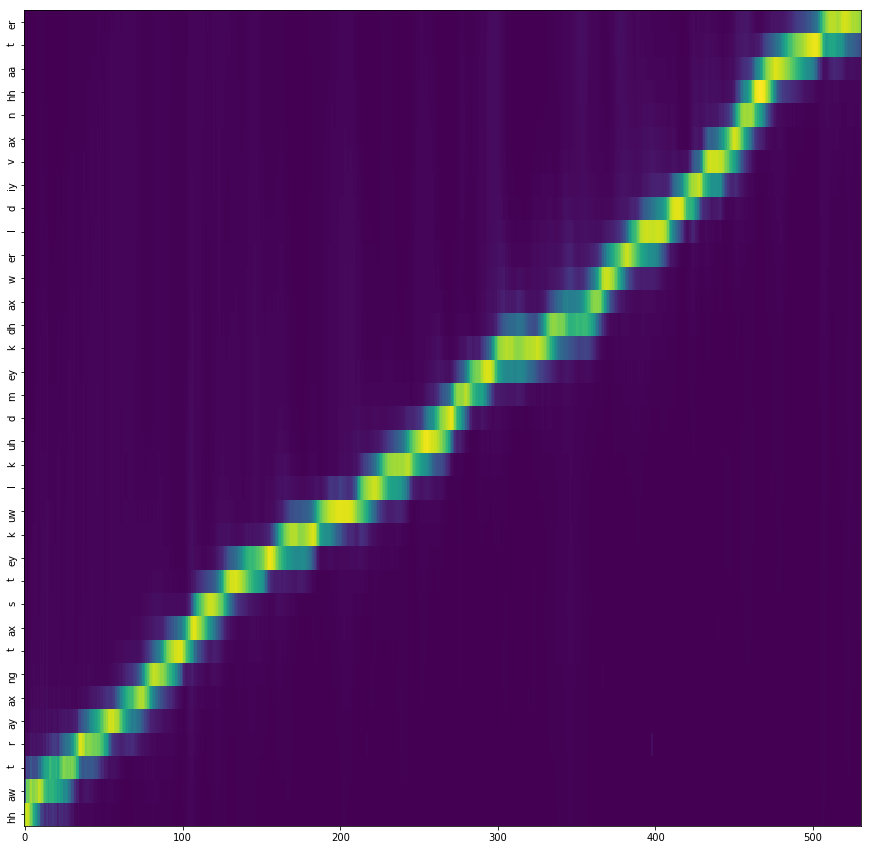

In [143]:
# attention plot
plot_attn(loop_dict['attn'], loop_dict['txt'], loader.dataset.dict)

### Use embedding vector directly

In [52]:
# generate the sample
spkr_id = 0
text = 'How trying to stay cool could make the world even hotter'
npz=''

In [53]:
e1 = copy.deepcopy(embeddings[39, :])
ident = Variable(torch.from_numpy(e1).unsqueeze(0)).cuda()
loop_dict_1 = generate_sample_with_loop(spkr_id=spkr_id, 
                                      npz=npz, 
                                      text=text, 
                                      checkpoint=checkpoint_file, 
                                      output_dir ='./',
                                        output_file_override='file1',
                                      npz_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features',
                                        ident_override=ident)

/home/ubuntu/loop/model_ident.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  g_t = self.sm(g_t) + self.epsilon


{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete file1.wav.


In [54]:
#e2 = copy.deepcopy(embeddings[55, :])
e2 = copy.deepcopy(embeddings[2, :])
ident = Variable(torch.from_numpy(e2).unsqueeze(0)).cuda()
loop_dict_1 = generate_sample_with_loop(spkr_id=spkr_id, 
                                      npz=npz, 
                                      text=text, 
                                      checkpoint=checkpoint_file, 
                                      output_dir ='./',
                                        output_file_override='file2',
                                      npz_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features',
                                        ident_override=ident)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete file2.wav.


In [55]:
e3 = 0.5*copy.deepcopy(e1) + 0.5*copy.deepcopy(e2)
ident = Variable(torch.from_numpy(e3).unsqueeze(0)).cuda()
loop_dict_1 = generate_sample_with_loop(spkr_id=spkr_id, 
                                      npz=npz, 
                                      text=text, 
                                      checkpoint=checkpoint_file, 
                                      output_dir ='./',
                                        output_file_override='file3',
                                      npz_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features',
                                        ident_override=ident)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete file3.wav.


In [56]:
# spkr 39
Audio('file1.wav', autoplay=True)

In [57]:
# spkr 55
Audio('file2.wav', autoplay=True)

In [58]:
# 50:50
Audio('file3.wav', autoplay=True)

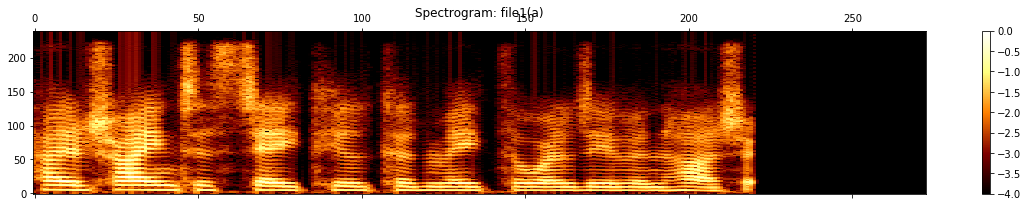

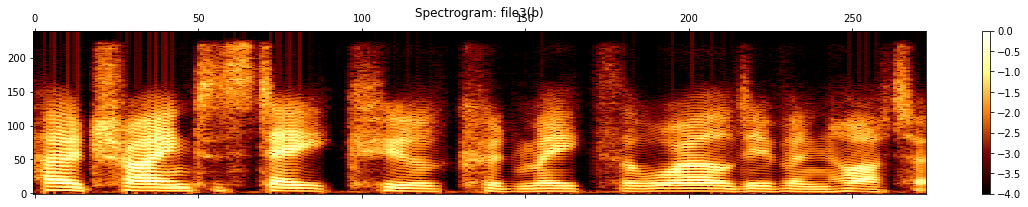

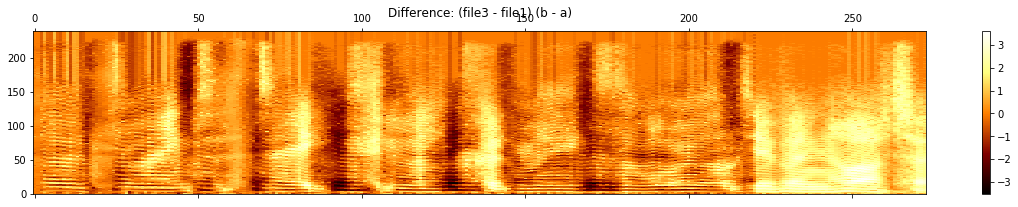

In [59]:
plot_spectrogram_comparison('file1', 'file3', 'a', 'b', b_mel=False)

In [60]:
cs = pw.cosine_similarity(np.vstack([e1, e3, e2]))

In [61]:
cs

array([[ 0.99999988,  0.70666963, -0.0338221 ],
       [ 0.70666963,  1.00000012,  0.68323779],
       [-0.0338221 ,  0.68323779,  1.00000024]], dtype=float32)

#### Male -> Female

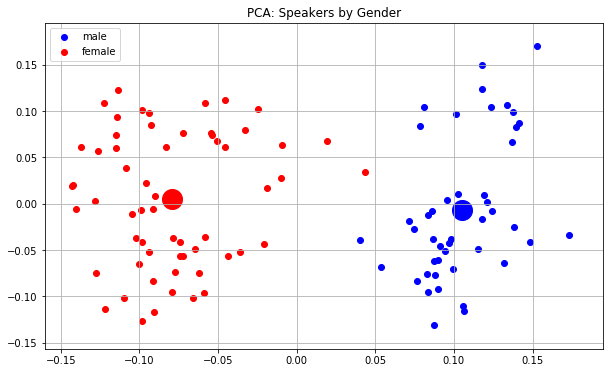

[[ 0.1880105  -0.02381199]]


In [62]:
# Find average male and average female
embedding_male = embeddings[idx_m, :].mean(0)
embedding_female = embeddings[idx_f, :].mean(0)

female_to_male = embedding_male - embedding_female

pca_male = pca.transform(embedding_male.reshape(1,256))
pca_female = pca.transform(embedding_female.reshape(1,256))

pca_trans = pca.transform(female_to_male.reshape(1,256))

plt.figure(figsize=(10,6))
m_plot = plt.scatter(pca_fit[idx_m, 0], pca_fit[idx_m, 1], c='b', label='male')
f_plot = plt.scatter(pca_fit[idx_f, 0], pca_fit[idx_f, 1], c='r', label='female')
leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('PCA: Speakers by Gender')

plt.scatter(pca_male[0,0], pca_male[0,1], c='b', s=400)
plt.scatter(pca_female[0,0], pca_female[0,1], c='r', s=400)
plt.show()

print(pca_trans)

In [63]:
pca_fit[39,:]

array([-0.10218642, -0.03739711], dtype=float32)

In [64]:
# generate the sample
spkr_id = 0
text = 'How trying to stay cool could make the world even hotter'
npz=''

In [70]:
#speaker_info_loop[speaker_info_loop.accents=='English']

In [73]:
speaker_info_loop[39:40]

,id,age,gender,accents,region
39,266,22,F,Irish,Athlone


In [76]:
e1 = copy.deepcopy(embeddings[39, :])
#e1 = copy.deepcopy(embeddings[47, :])
ident = Variable(torch.from_numpy(e1).unsqueeze(0)).cuda()
loop_dict_1 = generate_sample_with_loop(spkr_id=spkr_id, 
                                      npz=npz, 
                                      text=text, 
                                      checkpoint=checkpoint_file, 
                                      output_dir ='./',
                                        output_file_override='spkr39_irish_female',
                                      npz_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features',
                                        ident_override=ident)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete spkr39_irish_female.wav.


In [82]:
ident = Variable(torch.from_numpy(e1 + 2.0*female_to_male).unsqueeze(0)).cuda()
loop_dict_1 = generate_sample_with_loop(spkr_id=spkr_id, 
                                      npz=npz, 
                                      text=text, 
                                      checkpoint=checkpoint_file, 
                                      output_dir ='./',
                                        output_file_override='spkr39_irish_female_to_very_male',
                                      npz_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features',
                                        ident_override=ident)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete spkr39_irish_female_to_very_male.wav.


In [78]:
# spkr 39
Audio('spkr39_irish_female.wav', autoplay=True)

In [83]:
# spkr 39 -> female
Audio('spkr39_irish_female_to_very_male.wav', autoplay=True)

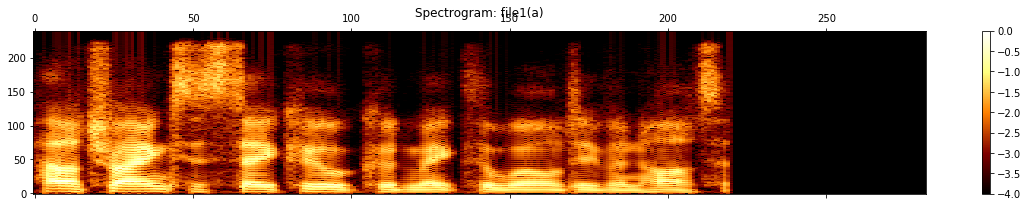

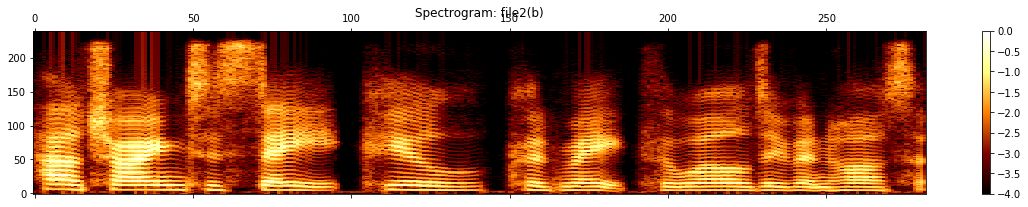

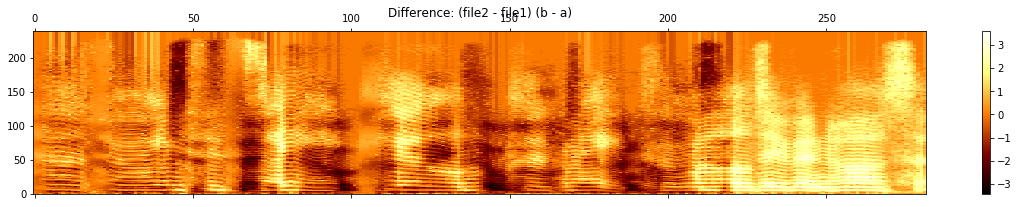

In [376]:
plot_spectrogram_comparison('file1', 'file2', 'a', 'b', b_mel=False)

In [392]:
cosine_sim_trans = pw.cosine_similarity(np.vstack([embeddings, e1 + female_to_male]))

In [393]:
t = speaker_info_loop.copy()

In [394]:
t = t.append({'id' : 107 , 'age' : 22, 'gender': 'M', 'accents': 'Irish', 'region': 'x'}, ignore_index=True)

In [395]:
t['cosine_sim'] = cosine_sim_trans[107, :]
t.sort_values('cosine_sim', ascending=False).head(10)

,id,age,gender,accents,region,cosine_sim
107,107,22,M,Irish,x,1.000000
39,266,22,F,Irish,Athlone,0.900006
48,275,23,M,Scottish,Midlothian,0.153997
46,273,23,M,English,Suffolk,0.152756
53,281,29,M,Scottish,Edinburgh,0.152197
90,334,18,M,American,Chicago,0.150710
43,270,21,M,English,Yorkshire,0.147493
97,345,22,M,American,Florida,0.146742
55,283,24,F,Irish,Cork,0.141899
11,237,22,M,Scottish,Fife,0.139813


In [396]:
t['cosine_sim'] = cosine_sim_trans[39, :]
t.sort_values('cosine_sim', ascending=False).head(10)

,id,age,gender,accents,region,cosine_sim
39,266,22,F,Irish,Athlone,1.000000
107,107,22,M,Irish,x,0.900006
55,283,24,F,Irish,Cork,0.241125
14,240,21,F,English,Southern England,0.207498
8,233,23,F,English,Staffordshire,0.181068
60,288,22,F,Irish,Dublin,0.168574
54,282,23,F,English,Newcastle,0.150175
3,228,22,F,English,Southern England,0.148729
73,305,19,F,American,Philadelphia,0.147192
22,249,22,F,Scottish,Aberdeen,0.144291


#### English -> American

In [85]:
#speaker_info_loop[speaker_info_loop.accents=='English']

In [86]:
# Find average male and average female
embedding_en = embeddings[speaker_info_loop.accents == 'English', :].mean(0)
embedding_am = embeddings[speaker_info_loop.accents == 'American', :].mean(0)

en_to_am = embedding_am - embedding_en

In [108]:
speaker_info_loop[14:15]

,id,age,gender,accents,region
14,240,21,F,English,Southern England


In [96]:
# generate the sample
spkr_id = 0
text = 'How trying to stay cool could make the world even hotter'
text = 'More than two million player ratings were awarded by users on the website'
npz=''

In [109]:
e1 = copy.deepcopy(embeddings[52, :])
e1 = copy.deepcopy(embeddings[59, :])
e1 = copy.deepcopy(embeddings[14, :]) # pretty good
#e1 = copy.deepcopy(embeddings[2, :]) # okay ish
#e1 = copy.deepcopy(embeddings[13, :]) # best so far
#e1 = copy.deepcopy(embeddings[23, :]) # reasonable, bit fast?
ident = Variable(torch.from_numpy(e1).unsqueeze(0)).cuda()
loop_dict_1 = generate_sample_with_loop(spkr_id=spkr_id, 
                                      npz=npz, 
                                      text=text, 
                                      checkpoint=checkpoint_file, 
                                      output_dir ='./',
                                        output_file_override='spkr14_female_english',
                                      npz_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features',
                                        ident_override=ident)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete spkr14_female_english.wav.


In [121]:
ident = Variable(torch.from_numpy(e1 + 1.0*en_to_am).unsqueeze(0)).cuda()
loop_dict_1 = generate_sample_with_loop(spkr_id=spkr_id, 
                                      npz=npz, 
                                      text=text, 
                                      checkpoint=checkpoint_file, 
                                      output_dir ='./',
                                        output_file_override='spkr14_female_english_to_american',
                                      npz_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features',
                                        ident_override=ident)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete spkr14_female_english_to_american.wav.


In [117]:
# english speaker
Audio('spkr14_female_english.wav', autoplay=True)

In [122]:
# english -> american
Audio('spkr14_female_english_to_american.wav', autoplay=True)

In [448]:
cosine_sim_trans = pw.cosine_similarity(np.vstack([embeddings, e1 + en_to_am]))

In [449]:
t = speaker_info_loop.copy()

In [450]:
t = t.append({'id' : 107 , 'age' : 21, 'gender': 'F', 'accents': 'English', 'region': 'transform en->am'}, ignore_index=True)

In [451]:
t['cosine_sim'] = cosine_sim_trans[107, :]
t.sort_values('cosine_sim', ascending=False).head(10)

,id,age,gender,accents,region,cosine_sim
107,107,21,F,English,transform en->am,1.000000
14,240,21,F,English,Southern England,0.904376
73,305,19,F,American,Philadelphia,0.318231
77,310,21,F,American,Tennessee,0.273018
39,266,22,F,Irish,Athlone,0.225300
76,308,18,F,American,Alabama,0.223373
9,234,22,F,Scottish,West Dumfries,0.206215
68,300,23,F,American,California,0.199003
93,339,21,F,American,Pennsylvania,0.174132
79,312,19,F,Canadian,Hamilton,0.169802


In [453]:
t['cosine_sim'] = cosine_sim_trans[14, :]
t.sort_values('cosine_sim', ascending=False).head(10)

,id,age,gender,accents,region,cosine_sim
14,240,21,F,English,Southern England,1.000000
107,107,21,F,English,transform en->am,0.904376
8,233,23,F,English,Staffordshire,0.222374
49,276,24,F,English,Oxford,0.215234
73,305,19,F,American,Philadelphia,0.211414
39,266,22,F,Irish,Athlone,0.207498
9,234,22,F,Scottish,West Dumfries,0.202803
60,288,22,F,Irish,Dublin,0.193537
4,229,23,F,English,Southern England,0.168803
3,228,22,F,English,Southern England,0.165392


## TODO
* Try random embeddings in the space but outside the existing speakers e.g. shows as outlier in PCA space. Does it work? Is speech intelligible? Generate random embeddings in the space, are they intelligible?
